In [1]:
%load_ext autoreload
%autoreload 2

import plotter
import analysis
import lmpsetup
import hmdsetup

import numpy as np
import matplotlib.pyplot as plt
import analysis

import mdtraj as md
import statsmodels.tsa.stattools

## Summary

Ramon wants this week to be a recap of all thing we're currently doing. 

**[1. HOOMD testing](#1)** : 

**[2. Frame aligment algorithm](#2)** : 

**[3. Phase diagrams](#3)** : 


### 1. HOOMD Testing <a id='1'></a>

We tried to perform an NVE to reduce possible noise. It turns out that LAMMPS was not considering 1st, 2nd and 3rd neighbors in HPS potential testing :

> Run Completed at 100.00% for None. Ran 100000 steps for a total of 2001 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
-22.2558972 -5.3193253


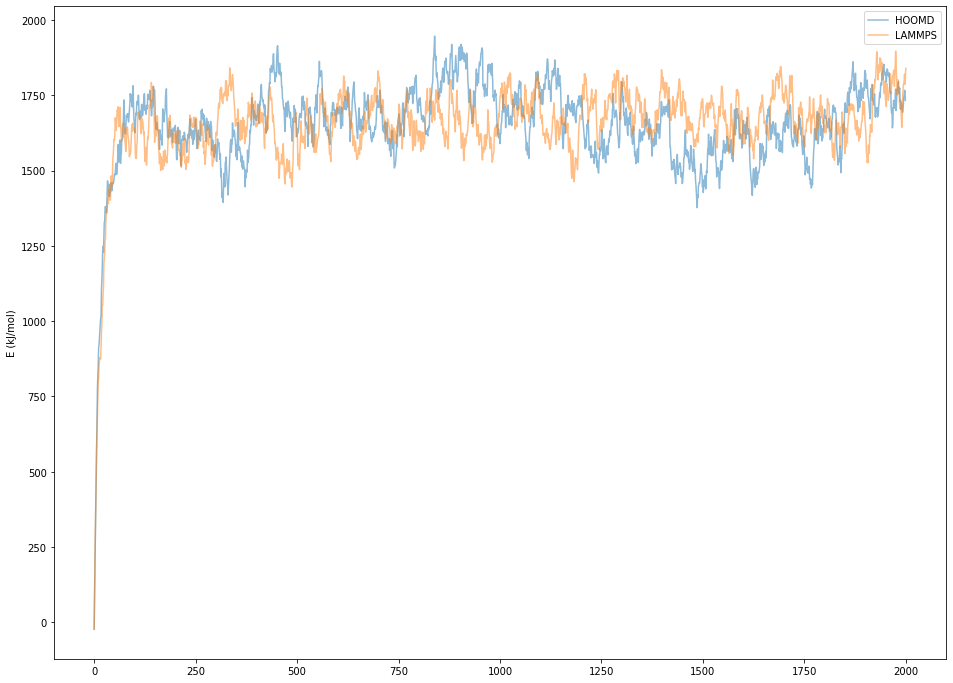

In [326]:
# red test
# HOOMD DATA
plt.figure(figsize=(16,12))
import os

hmd_dir = '/home/adria/irb/prod/HMDvsLMP/red-all_test'
with open(os.path.join(hmd_dir,'log_300.log'), 'r') as log:
    l = log.readlines()[1:]
hmd_data = np.genfromtxt(l)

# LAMMPS DATA
lmp = analysis.Analysis(oliba_wd='/home/adria/perdiux/all_test/red_test', equil_frames=0)
E_HMD = hmd_data[:,1]+hmd_data[:,2]
# E_HMD = hmd_data[:,3]
# E_HMD = hmd_data[:,4]
E_LMP = (lmp.data[0,:,1]+lmp.data[0,:,2])*4.184
# E_LMP = (lmp.data[0,:,3])*4.184
# E_LMP = (lmp.data[0,:,4])*4.184

print(hmd_data[0,1], lmp.data[0,0,1])
plt.plot(E_HMD, label='HOOMD', alpha=0.5)
plt.plot(E_LMP, label='LAMMPS', alpha=0.5)
plt.ylabel("E (kJ/mol)")
plt.legend()


Let's hope that this is now what makes the difference between HOOMD and LAMMPS :

In [323]:
temperatures = [300., 354.55, 427.27]
for temp in temperatures:
    hmdsetup.HMDSetup(protein='CPEB4', 
                      oliba_wd='/home/adria/irb/prod/FINAL', 
                      chains=1, 
                      save=5000,
                      box_size=200,
                      t=int(1e9),
                      temperature=temp).write_hps_files()
    
lmpsetup.LMPSetup(protein='CPEB4', 
                  oliba_wd='/home/adria/perdiux/all_test/FINAL', 
                  chains=1, 
                  save=5000,
                  box_size=200,
                  t=int(1e9),
                  host='@perdiu39',
                  processors=4,
                  temper=False,
                  debye=0.1,
                  temperatures=temperatures).write_hps_files()

╔═════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/all_test/FINAL for CPEB4     ║
║-----------------------------------------------------------------------------║
║   PARAMETERS                                                                ║
║       - Model = HPS                                                         ║
║       - Chains = 1                                                          ║
║       - Ionic Strength (mM) = 0.1                                           ║
║       - Medium Permittivity = 80.0                                          ║
║       - Temperatures (K) = [300.0, 354.55, 427.27]                          ║
║       - HPS Scale = 1.0                                                     ║
╚═════════════════════════════════════════════════════════════════════════════╝


Look at energies first :

> Run Completed at 0.09% for CPEB4. Ran 880000 steps for a total of 177 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
-22.25588389 -8.015755


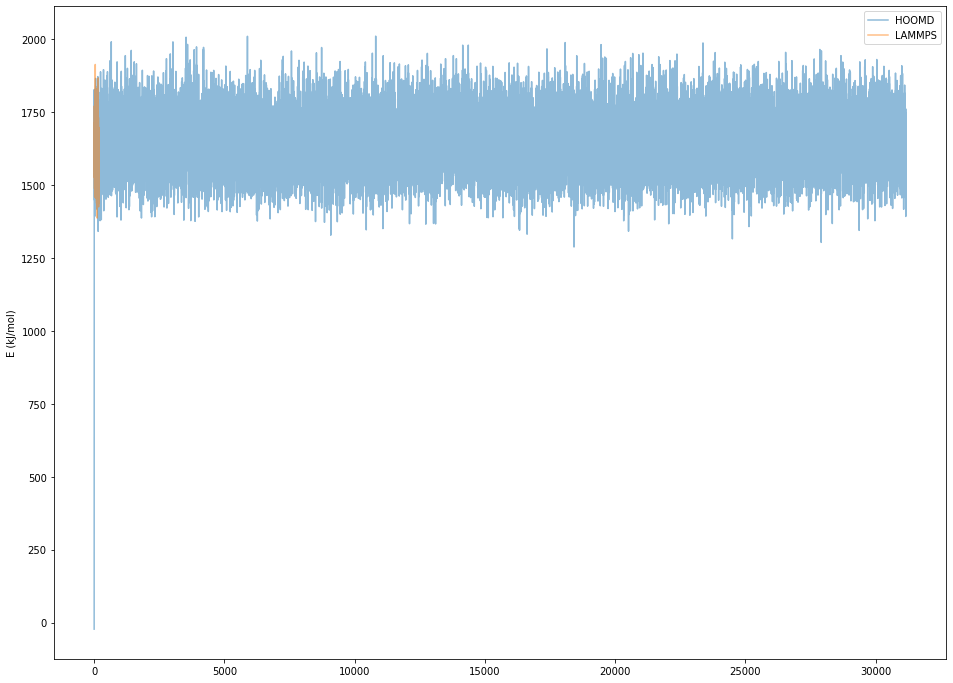

In [327]:
# red test
# HOOMD DATA
plt.figure(figsize=(16,12))
import os

hmd_dir = '/home/adria/irb/prod/FINAL'
with open(os.path.join(hmd_dir,'log_300.log'), 'r') as log:
    l = log.readlines()[1:]
hmd_data = np.genfromtxt(l)

# LAMMPS DATA
lmp = analysis.Analysis(oliba_wd='/home/adria/perdiux/all_test/FINAL', equil_frames=0)
E_HMD = hmd_data[:,1]+hmd_data[:,2]
# E_HMD = hmd_data[:,3]
# E_HMD = hmd_data[:,4]
E_LMP = (lmp.data[0,:,1]+lmp.data[0,:,2])*4.184
# E_LMP = (lmp.data[0,:,3])*4.184
# E_LMP = (lmp.data[0,:,4])*4.184

print(hmd_data[0,1], lmp.data[0,0,1])
plt.plot(E_HMD, label='HOOMD', alpha=0.5)
plt.plot(E_LMP, label='LAMMPS', alpha=0.5)
plt.ylabel("E (kJ/mol)")
plt.legend()


The rg's give : 

In [336]:
temperatures = [300,355,427]
hmd_rgs = []
for temp in temperatures:
    t = md.load(f'/home/adria/irb/prod/FINAL/trajectory_{temp}.dcd', top='/home/adria/irb/prod/FINAL/topo.pdb')
    rg = md.compute_rg(t)
    hmd_rgs.append(rg.mean()*100)

h = analysis.Analysis(oliba_wd='/home/adria/perdiux/all_test/FINAL')
lmp_rgs = h.rg().mean(axis=1)

> Run Completed at 0.09% for CPEB4. Ran 880000 steps for a total of 177 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations


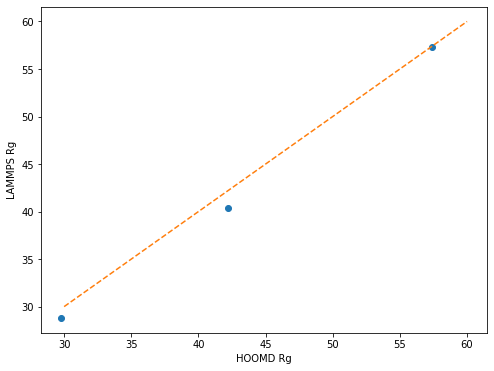

In [345]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.ylabel("LAMMPS Rg")
plt.xlabel("HOOMD Rg")
plt.plot(hmd_rgs, lmp_rgs, 'o')
plt.plot(np.linspace(30,60,100), np.linspace(30,60,100), '--')
# plt.plot(lmp_rgs)

### 2. Frame alignment algorithm <a id='2'></a>

We wish to implement the method from the paper : https://aip.scitation.org/doi/10.1063/1.5033958. Here is my attempt using artificial random noise on each frame:

In [2]:
test = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/CPEB4x50')

> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


In [3]:
coms = test.chain_coms()

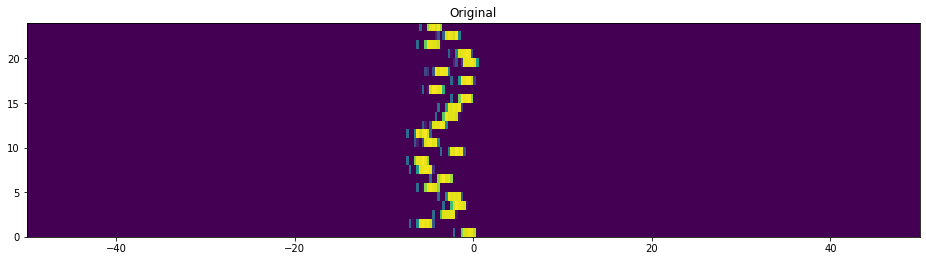

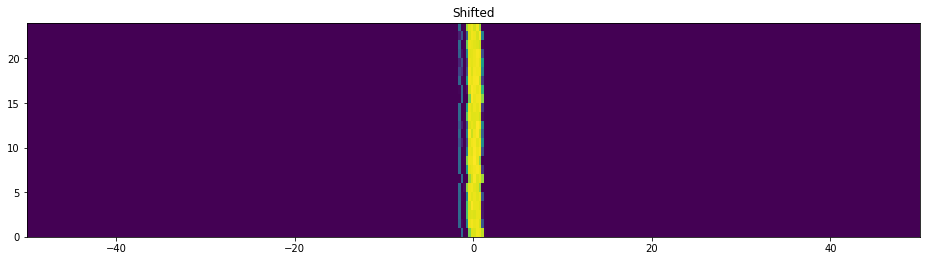

In [98]:
s = test.paper_density_profile(coms=coms);

> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


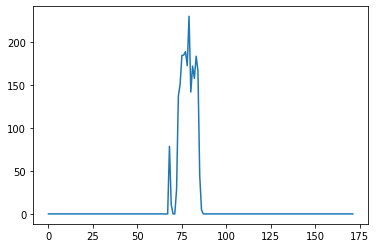

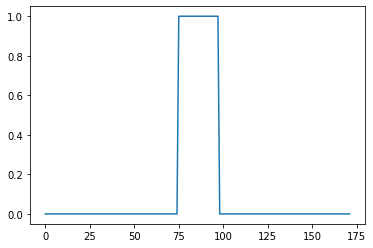

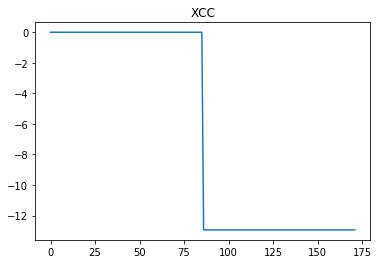

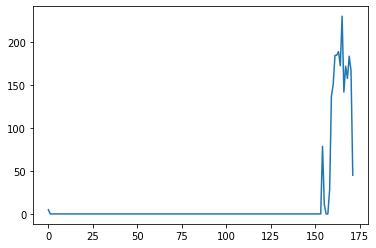

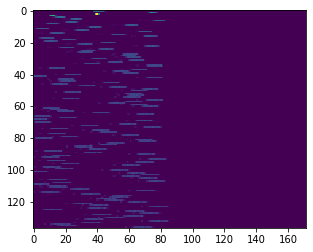

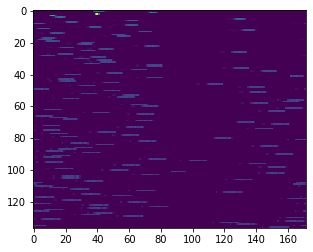

In [11]:
import analysis

wt_slab = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/CPEB4x50', equil_frames=0)
a, b, c = wt_slab.paper_density_profile(T=0, noise=True)

plt.figure()
plt.plot(c[-5,:])
plt.figure()
plt.imshow(b)
plt.figure()
plt.imshow(c)

83583500.0
83500.0


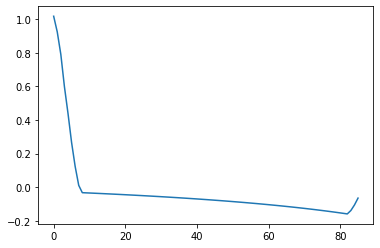

In [515]:
xa2 = np.linspace(0,1000,1001)
caa = []
for lag in range(0, 1):
    xa1 = xa2[lag:]
    xa_lag = xa2[:(len(xa2) - lag)]
    acf = np.sum((xa1 - xa2.mean()) * (xa_lag - xa2.mean()))
    print(acf)
    print(np.var(xa2))
    caa.append(acf / ((len(xa2) - lag) * np.var(xa2)))

# plt.plot(caa)

n = xa.shape[1]
caa = []
for lag in range(0, int(n/2)):
    xa1 = xa[:, lag:]
    xa_lag = xa[:, :(n - lag)]
    acf = np.sum((xa1 - xa.mean()) * (xa_lag - xa.mean()), axis=1)
    caa.append(acf / ((n - lag) * np.var(xa, axis=1)))
caa = np.array(caa)

plt.plot(caa[:,0])

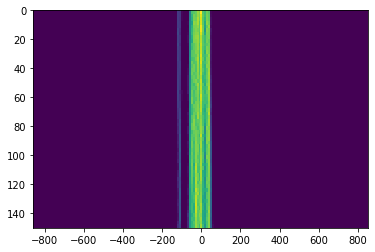

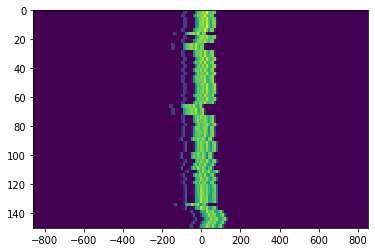

In [455]:
xar = xa[50:]
xsr = np.array(xshifts)[50:]
extent = [slab_bins.min(), slab_bins.max(), 150, 0]
plt.imshow(xar, extent=extent, aspect='auto')
plt.figure()
plt.imshow(xsr, extent=extent, aspect='auto')

Also, let's test Dignon's way of aligning :

In [ ]:
# rs = test.density_profile(T=0);

Let's apply it to a slab real example

In [356]:
wt_slab = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/CPEB4x50', equil_frames=0)

> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f096e8f08c0> (for post_execute):


ValueError: 
$ ho $
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$ ho $
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 432x288 with 1 Axes>

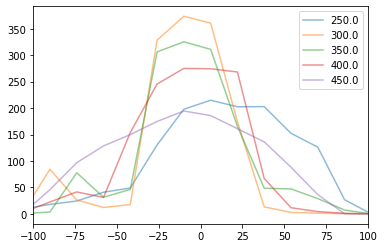

In [16]:
temps = [0, 1, 2, 3, 4]
temperatures = np.linspace(250,450,5)
plt.xlabel("z")
plt.ylabel("$ \rho $")
fig, ax = plt.subplots()
ax.set_xlim(-100,100)
for T in temps:
    slab_bins, xshifts = wt_slab.paper_density_profile(T=T)
    ax.plot(slab_bins, xshifts.mean(axis=0), label=temperatures[T], alpha=0.5)
ax.legend()

coms = wt_slab.chain_coms()

lims = {}
lims[250] = 70
lims[300] = 30
lims[350] = 40
lims[400] = 50
lims[450] = 80

[ -81.72777966  -76.19377257   86.54029727  -40.03164807  -38.14067935
   23.43156464  -83.98480931   77.3643623    55.66895273  -33.49103843
  -40.28297685  -55.45297721   -5.20674859  -46.53844021   64.45986935
 -255.95978109 -222.77264184 -290.59644934  -69.48303375  -13.80061746
   -2.5165001   -57.05246965  -50.10748292   49.29443867  -57.67993876
 -308.24118672  -65.01515102  -46.44526152  -73.26267673   53.76939646
  -28.43916299  -24.50014031   11.85426509   56.401899   -225.82471198
   57.34512739  -57.01827772  115.40493565   27.942645     77.94689524
   25.10200379   39.57377601  -65.03186989  114.53558113  -72.42357605
   -1.31514254   43.42694692  -47.9887123   -26.19026347  -31.96390751]
[0.07443396 0.05684906 0.06150943 0.06762264 0.07437736]


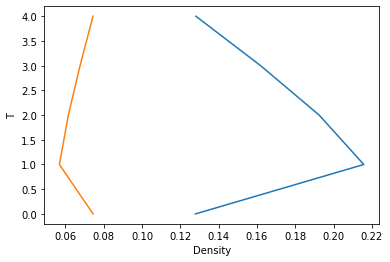

In [432]:
temps = [0, 1, 2, 3, 4]

rho_droplet = []
rho_free = []
print(coms[1,:,-5,2])
for T in temps:
    n = ((-50 < coms[T,:,:,2]) & (coms[T,:,:,2] < 50)).sum(axis=0)
    n_free = 50 - n
    rho_droplet.append(n/100)
    rho_free.append(n_free/500)
    nchains = coms[T,:,:,2]

print(np.array(rho_free).mean(axis=1))
plt.ylabel("T")
plt.xlabel("Density")
plt.plot(np.array(rho_droplet).mean(axis=1), temps)
plt.plot(np.array(rho_free).mean(axis=1), temps)

### 3. Phase diagrams <a id='3'></a>

For a start, consider 6 temperatures between 300K and 450K, for only two variants CPEB4 and CPEB4_D4. Also, consider an hydrophobicity strength of 1 and 0.7 between them.

In [17]:
np.linspace(250,450,5)

array([250., 300., 350., 400., 450.])

**$\lambda = 1$**

In [152]:
temperatures = np.linspace(250,450,5)
print(temperatures)

lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/CPEB4x50',
                  host='@perdiu34',
                  temper=False,
                  protein='CPEB4',
                  chains=50, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  use_random=True,
                  slab=True,
                  processors=3,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/CPEB4_D4x50',
                  host='@perdiu40',
                  temper=False,
                  protein='CPEB4_D4',
                  chains=50, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  use_random=True,
                  slab=True,
                  processors=3,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

[250. 300. 350. 400. 450.]
╔═════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/CPEB4x50 for CPEB4     ║
║---------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                            ║
║       - Model = HPS-T                                                                                   ║
║       - Chains = 50                                                                                     ║
║       - Ionic Strength (mM) = 0.1                                                                       ║
║       - Medium Permittivity = 80.0                                                                      ║
║       - Temperatures (K) = [250. 300. 350. 400. 450.]                                                   ║
║

**$\lambda = 0.7$**

In [153]:
temperatures = np.linspace(250,450,5)
print(temperatures)

lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/Red-CPEB4x50',
                  host='@perdiu43',
                  temper=False,
                  protein='CPEB4',
                  chains=50, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  use_random=True,
                  slab=True,
                  processors=3,
                  hps_scale=0.7,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

[250. 300. 350. 400. 450.]
╔═════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/Red-CPEB4x50 for CPEB4     ║
║-------------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                                ║
║       - Model = HPS-T                                                                                       ║
║       - Chains = 50                                                                                         ║
║       - Ionic Strength (mM) = 0.1                                                                           ║
║       - Medium Permittivity = 80.0                                                                          ║
║       - Temperatures (K) = [250. 300. 350. 400. 450.]                      

In [154]:

lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/Red-CPEB4_D4x50',
                  host='@perdiu42',
                  temper=False,
                  protein='CPEB4_D4',
                  chains=50, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  use_random=True,
                  slab=True,
                  processors=3,
                  hps_scale=0.7,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/Droplets/Red-CPEB4_D4x50 for CPEB4_D4     ║
║-------------------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                                      ║
║       - Model = HPS-T                                                                                             ║
║       - Chains = 50                                                                                               ║
║       - Ionic Strength (mM) = 0.1                                                                                 ║
║       - Medium Permittivity = 80.0                                                                                ║
║       - Temperatures (K) = [250. 300. 350. 400. 450.] 